## Librairies + importation

In [53]:
from pathlib import Path
from pyomeca import Analogs
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import feather
import csv
import re
import seaborn.objects as so
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain
import configparser
import tkinter as tk
from tkinter import filedialog

from datetime import date

today = date.today().strftime("%Y%m%d")

path_export = "C:/Users/l.boisson/Documents/ActivGun/Exports/"

sns.set_theme()
sns.set_style("white")

In [54]:
# Create a GUI window
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

## Définition des fonctions

In [55]:
def extract_file_info(file_path):
    match = re.match(r"(\d{3})_([A-Z]+)_([A-Z]+(?:\d{0,2}))_(\d{1,2})_(\d{2})", file_path)
    if match:
        participant = match.group(1)
        condition = match.group(2)
        contraction = match.group(3)
        essai = match.group(4)
        mesure = match.group(5)
        
        return {
            "participant": participant,
            "condition": condition,
            "contraction": contraction,
            "essai": essai,
            "mesure": mesure
        }
    else:
        print("Le nom de fichier ne correspond pas au modèle spécifié.")
        return None

def calcul_ratio(x):
    extension_values = x.loc[x.index.get_level_values('mouvement') == 'Extension', 'torque peak '].values
    flexion_values = x.loc[x.index.get_level_values('mouvement') == 'Flexion', 'torque peak '].values
    
    return flexion_values[0] / extension_values[0]

def process_data_participant(df, variable):
    df.columns =  ['participant', 'condition', 'contraction', 'mesure', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["mesure"], columns=["condition", "participant"])
    df = df[[variable, 'SD', 'CV']]
    return df

def process_data_essai(df, variable):
    df.columns =  ['participant', 'condition', 'contraction', 'mesure', 'essai', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["essai"], columns=["condition", "participant"])
    df = df[[variable, 'SD', 'CV']]
    return df

def process_data(df, variable):
    df.columns =  ['condition', 'contraction', 'mesure', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["mesure"], columns=["condition"])
    df = df[[variable, 'SD', 'CV']]
    return df

def process_data_essai_participant(df, variable):
    df.columns =  ['condition', 'contraction', 'mesure', 'essai', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["essai"], columns=["condition"])
    df = df[[variable, 'SD', 'CV']]
    return df

## Extraction données répétitions

In [56]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("**/*.cxp"):
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    contraction_type = file_info["contraction"]
    
    if contraction_type in ["EXC"]:
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=193,
            header=0,
            nrows=14,
            names=["variable", "1", "2", "3", "4", "5"],
        )
    if contraction_type in ["ISO"]:
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=134,
            header=0,
            nrows=14,
            names=["variable", "1"],
        )
    if contraction_type in ["CON60"]:
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=193,
            header=0,
            nrows=14,
            names=["variable", "1", "2", "3"],
        )
    data = data.assign(**file_info)

    df_column = pd.concat([df_column, data])

df_column

df_column["mouvement"] = df_column["variable"].str.extract(r"(\d+)$")
df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")
df_column["mouvement"] = df_column["mouvement"].astype(int)
df_column["mouvement"] = df_column["mouvement"].replace({1: "Extension", 2: "Flexion"})

df_result = df_column.melt(
    id_vars=[
        "participant",
        "condition",
        "contraction",
        "essai",
        "mesure",
        "mouvement",
        "variable"
    ],
    value_vars=["1", "2", "3", "4", "5"],
    var_name="Repetition",
    value_name="Valeur",
)
df_result
df_result["Valeur"] = df_result["Valeur"].abs()
df_result = df_result[
    [
        "participant",
        "condition",
        "contraction",        
        "essai",
        "mesure",
        "mouvement",
        "variable",
        "Repetition",
        "Valeur"
    ]
]

df_result.columns = [
    "participant",
    "condition",
    "contraction",
    "essai",
    "mesure",
    "mouvement",
    "Variable",
    "Repetition",
    "Valeur"
]

df_result = pd.pivot_table(
    df_result,
    index=[
        "participant",
        "condition",
        "contraction",
        "essai",
        "mesure",
        "Repetition",
        "mouvement",
    ],
    columns=["Variable"],
    values="Valeur",
)

df_result

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_15132\2868914683.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")


Variable                                                             power avg   \
participant condition contraction essai mesure Repetition mouvement               
001         CTRL      CON60       1     01     1          Extension  109.695454   
                                                          Flexion      8.007307   
                                               2          Extension  107.550337   
                                                          Flexion      4.902819   
                                               3          Extension   98.790250   
...                                                                         ...   
008         CTRL      ISO         2     02     1          Flexion      0.000000   
                                        11     1          Extension    0.299561   
                                                          Flexion      0.000000   
                                        21     1          Extension    0.031399   
                                                          Flexion      0.000000   

Variable                                                             power peak   \
participant condition contraction essai mesure Repetition mouvement                
001         CTRL      CON60       1     01     1          Extension   157.774421   
                                                          Flexion      56.522160   
                                               2          Extension   147.538033   
                                                          Flexion      19.797824   
                                               3          Extension   141.773556   
...                                                                          ...   
008         CTRL      ISO         2     02     1          Flexion       0.000000   
                                        11     1          Extension     0.872181   
                                                          Flexion       0.000000   
                                        21     1          Extension     0.922884   
                                                          Flexion       0.000000   

Variable                                                             speed peak   \
participant condition contraction essai mesure Repetition mouvement                
001         CTRL      CON60       1     01     1          Extension    60.533943   
                                                          Flexion      60.924488   
                                               2          Extension    60.533943   
                                                          Flexion      60.924488   
                                               3          Extension    60.533943   
...                                                                          ...   
008         CTRL      ISO         2     02     1          Flexion       0.000000   
                                        11     1          Extension     0.390542   
                                                          Flexion       0.390542   
                                        21     1          Extension     0.390542   
                                                          Flexion       0.000000   

Variable                                                             speed peak pos   \
participant condition contraction essai mesure Repetition mouvement                    
001         CTRL      CON60       1     01     1          Extension        60.055606   
                                                          Flexion          39.233333   
                                               2          Extension        50.716171   
                                                          Flexion          38.177651   
                                               3          Extension        61.369108   
...                                                                              ...   
008         CTRL      ISO     

## Rename colonnes

In [57]:
df_result.columns = ['Puissance_moyenne', 
                     'Pic_puissance', 
                     'Pic_vitesse', 
                     'Position_pic_vitesse', 
                     'Couple', 
                     'Position_couple', 
                     'Travail'
                     ]

df_result = df_result.drop(columns=['Puissance_moyenne', 'Pic_puissance', 'Pic_vitesse', 'Position_pic_vitesse'])

df_result

Couple  \
participant condition contraction essai mesure Repetition mouvement               
001         CTRL      CON60       1     01     1          Extension  150.664369   
                                                          Flexion    102.314064   
                                               2          Extension  141.010463   
                                                          Flexion     67.100861   
                                               3          Extension  135.121088   
...                                                                         ...   
008         CTRL      ISO         2     02     1          Flexion    252.453613   
                                        11     1          Extension  260.307495   
                                                          Flexion    254.203979   
                                        21     1          Extension  272.743286   
                                                          Flexion    256.141724   

                                                                     Position_couple  \
participant condition contraction essai mesure Repetition mouvement                    
001         CTRL      CON60       1     01     1          Extension        40.385126   
                                                          Flexion           2.903814   
                                               2          Extension        38.304272   
                                                          Flexion          81.536918   
                                               3          Extension        38.421739   
...                                                                              ...   
008         CTRL      ISO         2     02     1          Flexion          90.111365   
                                        11     1          Extension        90.111365   
                                                          Flexion          90.111365   
                                        21     1          Extension        90.109840   
                                                          Flexion          90.109840   

                                                                        Travail  
participant condition contraction essai mesure Repetition mouvement              
001         CTRL      CON60       1     01     1          Extension  171.827644  
                                                          Flexion     12.573975  
                                               2          Extension  165.946810  
                                                          Flexion      7.603200  
                                               3          Extension  155.903363  
...                                                                         ...  
008         CTRL      ISO         2     02     1          Flexion      0.000000  
                                        11     1          Extension    1.497807  
                                                          Flexion      0.000000  
                                        21     1          Extension    0.156995  
                                                          Flexion      0.000000  

[1100 rows x 3 columns]

### Fichiers EXC
10 essais, 5 rep - 1 extension (pas a prendre en compte) - 2 flexion

### Fichiers CON
1 essai 3 répétitions - 1 extension - 2 flexion (pas a prendre en compte)

### ISO
2 essais, 1 répétition - 1 extension - 2 flexion (pas a prendre en compte)

In [58]:
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'CON60') & (df_result.index.get_level_values('mouvement') == 'Flexion'))]
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'EXC') & (df_result.index.get_level_values('mouvement') == 'Extension'))]
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'ISO') & (df_result.index.get_level_values('mouvement') == 'Flexion'))]
df_result

Couple  \
participant condition contraction essai mesure Repetition mouvement               
001         CTRL      CON60       1     01     1          Extension  150.664369   
                                               2          Extension  141.010463   
                                               3          Extension  135.121088   
                                        02     1          Extension  123.656876   
                                               2          Extension  112.912658   
...                                                                         ...   
008         CTRL      ISO         1     21     1          Extension  281.019073   
                                  2     01     1          Extension  271.703461   
                                        02     1          Extension  266.125488   
                                        11     1          Extension  260.307495   
                                        21     1          Extension  272.743286   

                                                                     Position_couple  \
participant condition contraction essai mesure Repetition mouvement                    
001         CTRL      CON60       1     01     1          Extension        40.385126   
                                               2          Extension        38.304272   
                                               3          Extension        38.421739   
                                        02     1          Extension        50.214264   
                                               2          Extension        59.616247   
...                                                                              ...   
008         CTRL      ISO         1     21     1          Extension        90.109840   
                                  2     01     1          Extension        90.109840   
                                        02     1          Extension        90.111365   
                                        11     1          Extension        90.111365   
                                        21     1          Extension        90.109840   

                                                                        Travail  
participant condition contraction essai mesure Repetition mouvement              
001         CTRL      CON60       1     01     1          Extension  171.827644  
                                               2          Extension  165.946810  
                                               3          Extension  155.903363  
                                        02     1          Extension  135.300554  
                                               2          Extension  125.745896  
...                                                                         ...  
008         CTRL      ISO         1     21     1          Extension    0.093675  
                                  2     01     1          Extension    1.591299  
                                        02     1          Extension    0.364501  
                                        11     1          Extension    1.497807  
                                        21     1          Extension    0.156995  

[550 rows x 3 columns]

In [59]:
df_result.reset_index(inplace = True)
df_result

,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail
0,001,CTRL,CON60,1,01,1,Extension,150.664369,40.385126,171.827644
1,001,CTRL,CON60,1,01,2,Extension,141.010463,38.304272,165.946810
2,001,CTRL,CON60,1,01,3,Extension,135.121088,38.421739,155.903363
3,001,CTRL,CON60,1,02,1,Extension,123.656876,50.214264,135.300554
4,001,CTRL,CON60,1,02,2,Extension,112.912658,59.616247,125.745896
...,...,...,...,...,...,...,...,...,...,...
545,008,CTRL,ISO,1,21,1,Extension,281.019073,90.109840,0.093675
546,008,CTRL,ISO,2,01,1,Extension,271.703461,90.109840,1.591299
547,008,CTRL,ISO,2,02,1,Extension,266.125488,90.111365,0.364501
548,008,CTRL,ISO,2,11,1,Extension,260.307495,90.111365,1.497807


In [88]:
test = df_result.reset_index()
test[(test.participant == '007') & (test.contraction == 'CON60')]

,index,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail,poids,Couple_normalise,Travail_normalise
410,410,007,CTRL,CON60,1,01,1,Extension,214.860231,71.673532,170.040757,74.3,2.891793,2.288570
411,411,007,CTRL,CON60,1,01,2,Extension,210.454684,76.463768,180.134970,74.3,2.832499,2.424428
412,412,007,CTRL,CON60,1,01,3,Extension,192.259997,75.542334,168.418945,74.3,2.587618,2.266742
413,413,007,CTRL,CON60,1,02,1,Extension,208.649216,74.704805,152.685067,74.3,2.808199,2.054981
414,414,007,CTRL,CON60,1,02,2,Extension,198.639450,77.296720,162.419534,74.3,2.673478,2.185996
415,415,007,CTRL,CON60,1,02,3,Extension,186.188278,80.518688,162.556009,74.3,2.505899,2.187833
416,416,007,CTRL,CON60,1,11,1,Extension,108.795700,58.212052,56.610077,74.3,1.464276,0.761912
417,417,007,CTRL,CON60,1,11,2,Extension,180.573044,81.154844,139.949069,74.3,2.430324,1.883568
418,418,007,CTRL,CON60,1,11,3,Extension,172.760544,82.093059,143.070897,74.3,2.325176,1.925584
419,419,007,CTRL,CON60,1,21,1,Extension,178.143981,75.772693,110.928825,74.3,2.397631,1.492986


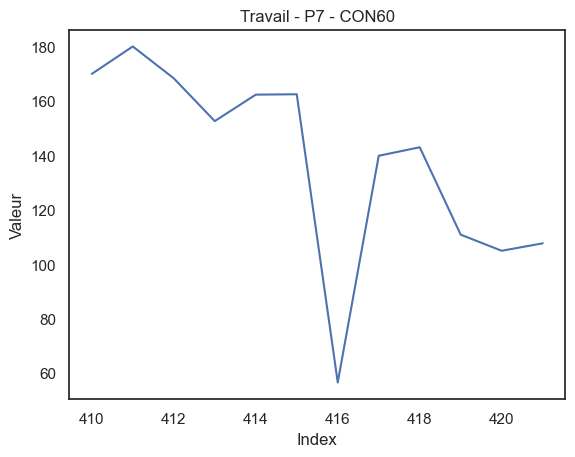

In [96]:
filtered_data = test[(test['participant'] == '007') & (test['contraction'] == 'CON60')]
travail_values = filtered_data['Travail']

plt.plot(travail_values)
plt.xlabel('Index')
plt.ylabel('Valeur')
plt.title('Travail - P7 - Con60')
plt.show()

## Fichier poids pour normalisation

In [60]:
poids_file_path = "C:/Users/l.boisson/Documents/ActivGun/240327_ActivGun_Donnees_anthropometriques.xlsx"
poids_file = pd.DataFrame()
sheet_name = f'Composition_corporelle'
poids_file = pd.read_excel(poids_file_path, sheet_name=sheet_name, header=[0], nrows=2).iloc[:, 1:-2]
poids_file = poids_file.drop(poids_file.index[0]) 
poids_file.columns = poids_file.columns.str.replace('P', '')
poids_file = poids_file.melt(var_name='participant', value_name='poids')
poids_file

,participant,poids
0,001,61.0
1,002,68.2
2,003,82.9
3,004,61.9
4,005,90.5
5,006,107.6
6,007,74.3
7,008,70.0


In [61]:
df_result = pd.merge(df_result, poids_file, on="participant", how="left")
df_result["Couple_normalise"] = df_result["Couple"].div(df_result["poids"])
df_result["Travail_normalise"] = df_result["Travail"].div(df_result["poids"])
df_result

,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail,poids,Couple_normalise,Travail_normalise
0,001,CTRL,CON60,1,01,1,Extension,150.664369,40.385126,171.827644,61.0,2.469908,2.816847
1,001,CTRL,CON60,1,01,2,Extension,141.010463,38.304272,165.946810,61.0,2.311647,2.720440
2,001,CTRL,CON60,1,01,3,Extension,135.121088,38.421739,155.903363,61.0,2.215100,2.555793
3,001,CTRL,CON60,1,02,1,Extension,123.656876,50.214264,135.300554,61.0,2.027162,2.218042
4,001,CTRL,CON60,1,02,2,Extension,112.912658,59.616247,125.745896,61.0,1.851027,2.061408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,008,CTRL,ISO,1,21,1,Extension,281.019073,90.109840,0.093675,70.0,4.014558,0.001338
546,008,CTRL,ISO,2,01,1,Extension,271.703461,90.109840,1.591299,70.0,3.881478,0.022733
547,008,CTRL,ISO,2,02,1,Extension,266.125488,90.111365,0.364501,70.0,3.801793,0.005207
548,008,CTRL,ISO,2,11,1,Extension,260.307495,90.111365,1.497807,70.0,3.718679,0.021397


# Livrables CON60 par participant

In [62]:
df_result_con60 = df_result[df_result.contraction == 'CON60']

con60_couple_mean = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_couple_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_max_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_pos_couple_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_travail_moyen = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_moyen_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

con60_couple_mean = process_data_participant(con60_couple_mean, 'Couple_moyen')
con60_couple_max = process_data_participant(con60_couple_max, 'Couple_max')
con60_couple_max_normalise = process_data_participant(con60_couple_max_normalise, 'Couple_max_normalise')
con60_pos_couple_max = process_data_participant(con60_pos_couple_max, 'Position_couple_max')
con60_travail_moyen = process_data_participant(con60_travail_moyen, 'Travail_moyen')
con60_travail_moyen_normalise = process_data_participant(con60_travail_moyen_normalise, 'Travail_moyen_normalise')
con60_travail_max = process_data_participant(con60_travail_max, 'Travail_max')

In [63]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_concentrique_participant.xlsx") as writer:
    con60_couple_mean.to_excel(writer, sheet_name='Con60_Couple_moyen')
    con60_couple_max.to_excel(writer, sheet_name='Con60_Couple_max')
    con60_couple_max_normalise.to_excel(writer, sheet_name='Con60_Couple_max_normalise')
    con60_pos_couple_max.to_excel(writer, sheet_name='Con60_Pos_couple_max')
    con60_travail_moyen.to_excel(writer, sheet_name='Con60_Travail_moyen')
    con60_travail_moyen_normalise.to_excel(writer, sheet_name='Con60_Travail_moyen_normalise')
    con60_travail_max.to_excel(writer, sheet_name='Con60_Travail_max')

# Livrables CON60 participants moyennés

In [64]:
df_result_con60 = df_result[df_result.contraction == 'CON60']

con60_couple_mean = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_couple_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_max_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_pos_couple_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_travail_moyen = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_moyen_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

con60_couple_mean = process_data(con60_couple_mean, 'Couple_moyen')
con60_couple_max = process_data(con60_couple_max, 'Couple_max')
con60_couple_max_normalise = process_data(con60_couple_max_normalise, 'Couple_max_normalise')
con60_pos_couple_max = process_data(con60_pos_couple_max, 'Position_couple_max')
con60_travail_moyen = process_data(con60_travail_moyen, 'Travail_moyen')
con60_travail_moyen_normalise = process_data(con60_travail_moyen_normalise, 'Travail_moyen_normalise')
con60_travail_max = process_data(con60_travail_max, 'Travail_max')
con60_couple_mean

,Couple_moyen,SD,CV
condition,CTRL,CTRL,CTRL
mesure,,,
01,200.028313,47.237064,0.231180
02,184.482241,42.735662,0.226774
11,154.783245,45.071685,0.284175
21,158.303578,46.717023,0.287998


In [65]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_concentrique.xlsx") as writer:
    con60_couple_mean.to_excel(writer, sheet_name='Con60_Couple_moyen')
    con60_couple_max.to_excel(writer, sheet_name='Con60_Couple_max')
    con60_couple_max_normalise.to_excel(writer, sheet_name='Con60_Couple_max_normalise')
    con60_pos_couple_max.to_excel(writer, sheet_name='Con60_Pos_couple_max')
    con60_travail_moyen.to_excel(writer, sheet_name='Con60_Travail_moyen')
    con60_travail_moyen_normalise.to_excel(writer, sheet_name='Con60_Travail_moyen_normalise')
    con60_travail_max.to_excel(writer, sheet_name='Con60_Travail_max')

# Livrable couple moyen ISO par participant

In [66]:
df_result_iso = df_result[df_result.contraction == 'ISO']
iso_couple_mean = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_couple_max = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_max_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_travail_moyen = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_moyen_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_max = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

iso_couple_mean = process_data_participant(iso_couple_mean, 'Couple_moyen')
iso_couple_max = process_data_participant(iso_couple_max, 'Couple_max')
iso_couple_max_normalise = process_data_participant(iso_couple_max_normalise, 'Couple_max_normalise')
iso_travail_moyen = process_data_participant(iso_travail_moyen, 'Travail_moyen')
iso_travail_moyen_normalise = process_data_participant(iso_travail_moyen_normalise, 'Travail_moyen_normalise')
iso_travail_max = process_data_participant(iso_travail_max, 'Travail_max')
iso_couple_max_normalise

Couple_max_normalise                                          \
condition                   CTRL                                           
participant                  001       002       003       004       005   
mesure                                                                     
01                      2.965345  3.341919  2.812849  2.742638  3.408159   
02                      2.610138  3.393759  2.646131  2.828508  3.104459   
11                      2.310645  2.890746  2.497160  2.180766       NaN   
21                      2.301059  3.061932  2.299620  1.971718       NaN   

                                                 SD            ...            \
condition                                      CTRL            ...             
participant       006       007       008       001       002  ...       007   
mesure                                                         ...             
01           3.115177  3.081814  4.082043  0.249462  0.036417  ...  0.389221   
02           2.955442  2.983036  3.801793  0.087957  0.084433  ...  0.089829   
11           2.648585  2.709184  3.718679  0.042049  0.104431  ...  0.084994   
21           2.657911  2.517182  4.014558  0.155311  0.193992  ...  0.012195   

                             CV                                          \
condition                  CTRL                                           
participant       008       001       002       003       004       005   
mesure                                                                    
01           0.141821  0.059486  0.007705  0.033481  0.019720  0.020184   
02           0.112657  0.023828  0.017592  0.021508  0.043221  0.001185   
11           0.019808  0.012868  0.025545  0.059161  0.017476       NaN   
21           0.083598  0.047726  0.044800  0.009299  0.081099       NaN   

                                           
condition                                  
participant       006       007       008  
mesure                                     
01           0.027314  0.089305  0.024567  
02           0.034010  0.021293  0.020953  
11           0.029972  0.022184  0.003767  
21           0.059104  0.003426  0.014725  

[4 rows x 24 columns]

In [67]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_isometrique_participant.xlsx") as writer:
    iso_couple_mean.to_excel(writer, sheet_name='Iso_Couple_moyen')
    iso_couple_max.to_excel(writer, sheet_name='Iso_Couple_max')
    iso_couple_max_normalise.to_excel(writer, sheet_name='Iso_Couple_max_normalise')
    iso_travail_moyen.to_excel(writer, sheet_name='Iso_Travail_moyen')
    iso_travail_moyen_normalise.to_excel(writer, sheet_name='Iso_Travail_moyen_normalise')
    iso_travail_max.to_excel(writer, sheet_name='Iso_Travail_max')

# Livrable couple moyen ISO participants moyennés

In [68]:
df_result_iso = df_result[df_result.contraction == 'ISO']
iso_couple_mean = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_couple_max = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_max_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_travail_moyen = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_moyen_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_max = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

iso_couple_mean = process_data(iso_couple_mean, 'Couple_moyen')
iso_couple_max = process_data(iso_couple_max, 'Couple_max')
iso_couple_max_normalise = process_data(iso_couple_max_normalise, 'Couple_max_normalise')
iso_travail_moyen = process_data(iso_travail_moyen, 'Travail_moyen')
iso_travail_moyen_normalise = process_data(iso_travail_moyen_normalise, 'Travail_moyen_normalise')
iso_travail_max = process_data(iso_travail_max, 'Travail_max')
iso_couple_max_normalise

,Couple_max_normalise,SD,CV
condition,CTRL,CTRL,CTRL
mesure,,,
01,4.082043,0.450658,0.106894
02,3.801793,0.394953,0.100587
11,3.718679,0.506908,0.131356
21,4.014558,0.672285,0.161370


In [69]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_isometrique.xlsx") as writer:
    iso_couple_mean.to_excel(writer, sheet_name='Iso_Couple_moyen')
    iso_couple_max.to_excel(writer, sheet_name='Iso_Couple_max')
    iso_couple_max_normalise.to_excel(writer, sheet_name='Iso_Couple_max_normalise')
    iso_travail_moyen.to_excel(writer, sheet_name='Iso_Travail_moyen')
    iso_travail_moyen_normalise.to_excel(writer, sheet_name='Iso_Travail_moyen_normalise')
    iso_travail_max.to_excel(writer, sheet_name='Iso_Travail_max')

# Livrable couple moyen EXC par participant

In [70]:
df_result_exc = df_result[df_result.contraction == 'EXC']

exc_travail_moyen_participant_essai = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant_essai_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()

exc_travail_moyen_participant_essai = process_data_essai(exc_travail_moyen_participant_essai, 'Travail_moyen_essai')
exc_travail_moyen_participant_essai_normalise = process_data_essai(exc_travail_moyen_participant_essai_normalise, 'Travail_moyen_essai_normalise')
exc_travail_moyen_participant = process_data_participant(exc_travail_moyen_participant, 'Travail_moyen')
exc_travail_moyen_participant_normalise = process_data_participant(exc_travail_moyen_participant_normalise, 'Travail_moyen_normalise')
exc_travail_moyen_participant_normalise

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_15132\2342732002.py:37: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df = df.pivot_table(index=["essai"], columns=["condition", "participant"])
C:\Users\l.boisson\AppData\Local\Temp\ipykernel_15132\2342732002.py:37: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  df = df.pivot_table(index=["essai"], columns=["condition", "participant"])


Travail_moyen_normalise                                          \
condition                      CTRL                                           
participant                     001       002       003       004       005   
mesure                                                                        
00                         2.668331  2.495157  2.697929  2.987851  2.900519   

                                                 SD            ...            \
condition                                      CTRL            ...             
participant       006       007       008       001       002  ...       007   
mesure                                                         ...             
00           2.514405  2.423007  3.081046  0.278642  0.292244  ...  0.465798   

                             CV                                          \
condition                  CTRL                                           
participant       008       001       002       003       004       005   
mesure                                                                    
00           0.483397  0.103376  0.115947  0.160131  0.147941  0.214256   

                                           
condition                                  
participant       006       007       008  
mesure                                     
00           0.115144  0.190308  0.155317  

[1 rows x 24 columns]

In [71]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_excentrique_participant.xlsx") as writer:
    exc_travail_moyen_participant_essai.to_excel(writer, sheet_name='Exc_Travail_moyen_E')
    exc_travail_moyen_participant_essai_normalise.to_excel(writer, sheet_name='Exc_Travail_moyen_normalise_E')
    exc_travail_moyen_participant.to_excel(writer, sheet_name='Exc_Travail_moyen')
    exc_travail_moyen_participant_normalise.to_excel(writer, sheet_name='Exc_Travail_moyen_normalise')

# Livrable couple moyen EXC participant moyennés

In [72]:
df_result_exc = df_result[df_result.contraction == 'EXC']

exc_travail_moyen_essai = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_essai_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen = df_result_exc.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()

exc_travail_moyen_essai = process_data_participant(exc_travail_moyen_essai, 'Travail_moyen_essai')
exc_travail_moyen_essai_normalise = process_data_participant(exc_travail_moyen_essai_normalise, 'Travail_moyen_essai_normalise')
exc_travail_moyen = process_data(exc_travail_moyen, 'Travail_moyen')
exc_travail_moyen_normalise = process_data(exc_travail_moyen_normalise, 'Travail_moyen_normalise')
exc_travail_moyen

,Travail_moyen,SD,CV
condition,CTRL,CTRL,CTRL
mesure,,,
00,208.786722,51.427711,0.246009


In [73]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_excentrique.xlsx") as writer:
    exc_travail_moyen_essai.to_excel(writer, sheet_name='Exc_Travail_moyen_E')
    exc_travail_moyen_essai_normalise.to_excel(writer, sheet_name='Exc_Travail_moyen_normalise_E')
    exc_travail_moyen.to_excel(writer, sheet_name='Exc_Travail_moyen')
    exc_travail_moyen_normalise.to_excel(writer, sheet_name='Exc_Travail_moyen_normalise')